## Project Details
Our client is an Insurance company that has provided Health Insurance to its customers now they need your help in building a model to predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company.

For example, you may pay a premium of Rs. 5000 each year for a health insurance cover of Rs. 200,000/- so that if, God forbid, you fall ill and need to be hospitalised in that year, the insurance provider company will bear the cost of hospitalisation etc. for upto Rs. 200,000. Now if you are wondering how can company bear such high hospitalisation cost when it charges a premium of only Rs. 5000/-, that is where the concept of probabilities comes in picture. For example, like you, there may be 100 customers who would be paying a premium of Rs. 5000 every year, but only a few of them (say 2-3) would get hospitalised that year and not everyone. This way everyone shares the risk of everyone else.

Just like medical insurance, there is vehicle insurance where every year customer needs to pay a premium of certain amount to insurance provider company so that in case of unfortunate accident by the vehicle, the insurance provider company will provide a compensation (called ‘sum assured’) to the customer.

## Business Goal
Building a model to predict whether a customer would be interested in Vehicle Insurance is extremely helpful for the company because it can then accordingly plan its communication strategy to reach out to those customers and optimise its business model and revenue.

Now, in order to predict, whether the customer would be interested in Vehicle insurance, you have information about demographics (gender, age, region code type), Vehicles (Vehicle Age, Damage), Policy (Premium, sourcing channel) etc.

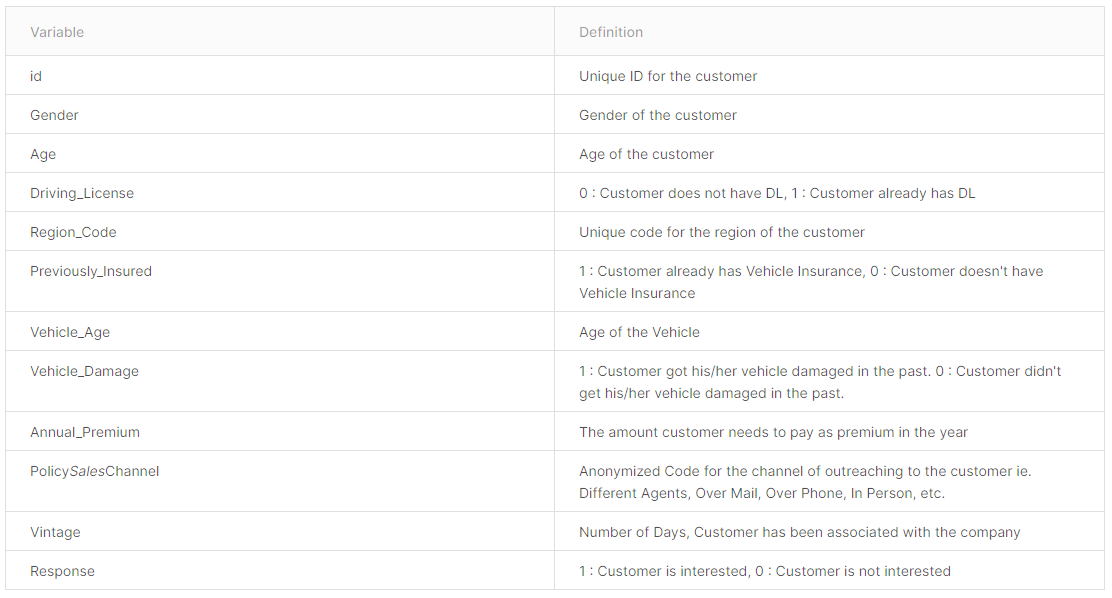

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Import Dataset

In [ ]:
train=pd.read_csv('../input/health-insurance-cross-sell-prediction/train.csv')
holdout=pd.read_csv('../input/health-insurance-cross-sell-prediction/test.csv')

In [ ]:
train.head()

In [ ]:
train.isnull().sum()

There is no missing data.

In [ ]:
#looking at the info to get an idea on the numeric and the string columns.
train.info()

## Exploratory Data Analysis

### Gender Analysis

In [ ]:
plt.figure(figsize = (13,5))
plt.subplot(1,2,1)
sns.countplot(train['Gender'])
plt.title("Gender Distribution")
plt.subplot(1,2,2)
sns.barplot(x="Gender", y="Response", data=train)
plt.title("Response by gender")
plt.show()

Gender Distribution is almost equal, a bit higher for male, as it is also the probability to get an interested response.   
The interested response represents a values close to 14% for male and to 10% for female.

### Age Distribution


In [ ]:
sns.distplot(train['Age'], hist = False, kde = True, kde_kws = {'linewidth': 3})
    

The most of our customers are in the range of age 20-30 years old. We should ask ourselves as a company why we dont have more customers in the range of 30-40 years old.

In [ ]:
train['Age'].describe()

The youngest client is 20 years old and the oldest 85, it looks quite fair then we consider that there is not outliers in the data.

In [ ]:
train['Driving_License'].value_counts()

There is 812 people with no driving license, even when they could be interested we could think to get them off of the data, considering that we shouldnt ensure people without driving license.

### Vehicle_Age

In [ ]:
#Lets show the number of observations in each category.
sns.catplot(x="Vehicle_Age", kind="count", palette="ch:0.25", data=train)

In [ ]:
# lets obtain the estimate for the different categories of Vehicle_Age and Gender.
sns.catplot(x="Gender", y="Response", hue="Vehicle_Age", kind="bar", data=train)

We can see for example that the quantity of vehicles older than 2 years is the lowest but at the same time they are the more interested in a vehicle insurance.

### Vehicle Damaged

In [ ]:
train['Vehicle_Damage'].value_counts()

In [ ]:
sns.barplot(x="Vehicle_Damage", y="Response", data=train)
plt.title("Response by Vehicle_Damage")

People that had their vehicle damaged previously are much more interested in a vehicle insurance.  

### Annual Premium

In [ ]:
sns.distplot(train['Annual_Premium'], hist = False, kde = True, kde_kws = {'linewidth': 3})

In [ ]:
train['Annual_Premium'].plot(kind='box')

In [ ]:
train['Annual_Premium'].describe()

We have a really high variability in the premium price, we should recheck it, maybe comparing with another data base the kind of cars vehicle that is insured. 

### Vintage distribution

In [ ]:
sns.distplot(train['Vintage'], hist = False, kde = True, kde_kws = {'linewidth': 3})

In [ ]:
corr_train = train.corr()
sorted_corrs = abs(corr_train['Response']).sort_values(ascending=False)
sorted_corrs
#sns.heatmap(corr_train)

## Preprocessing the Data


In [ ]:
numeric_cols = ['Age', 'Annual_Premium','Vintage']
cat_cols =['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Policy_Sales_Channel']

In [ ]:
train['Gender'] = train['Gender'].map({'Female':0, 'Male':1})
train['Vehicle_Age'] = train['Vehicle_Age'].map({'< 1 Year':0, '1-2 Year':1, '> 2 Years':2})
train['Vehicle_Damage'] = train['Vehicle_Damage'].map({'No':0, 'Yes':1})

train[cat_cols] = train[cat_cols].astype('category')

train.head()

In [ ]:
#Lets rescale numerical data.

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train[numeric_cols] = scaler.fit_transform(train[numeric_cols])

In [ ]:
features = train.columns.drop(['id','Response'])

all_X = train[features]
all_y = train['Response']

from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(all_X, all_y, test_size= 0.2)

### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

hyperparameters = {
                        "n_estimators": [4, 6, 9],
                        "criterion": ["entropy", "gini"],
                        "max_depth": [2, 5, 10],
                        "max_features": ["log2", "sqrt"],
                        "min_samples_leaf": [1, 5, 8],
                        "min_samples_split": [2, 3, 5]
                        }

clf = RandomForestClassifier()
grid = GridSearchCV(clf, param_grid=hyperparameters, cv=3)
grid.fit(train_X, train_y)

In [ ]:
grid.best_estimator_

In [ ]:
print("Best Score: {}".format(grid.best_score_))
print("Best Parameters: {}\n".format(grid.best_params_))

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, classification_report

test_pred = grid.predict(test_X)


In [ ]:
print (classification_report(test_y, test_pred))

### AUC of Random forest classifier

In [ ]:
pred_prob = grid.predict_proba(test_X)
# roc curve for models
fpr, tpr, thresh = roc_curve(test_y, pred_prob[:,1], pos_label=1)

In [ ]:
# auc scores
auc_score = roc_auc_score(test_y, pred_prob[:,1])
print(auc_score)

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr, tpr, linestyle='--',color='orange', label='Random forest classifier')

# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.show();

## Final Test Data Submission

In [ ]:
holdout['Gender'] = holdout['Gender'].map({'Female':0, 'Male':1})
holdout['Vehicle_Age'] = holdout['Vehicle_Age'].map({'< 1 Year':0, '1-2 Year':1, '> 2 Years':2})
holdout['Vehicle_Damage'] = holdout['Vehicle_Damage'].map({'No':0, 'Yes':1})

holdout[cat_cols] = holdout[cat_cols].astype('category')

holdout[numeric_cols] = scaler.fit_transform(holdout[numeric_cols])
holdout.head()

In [ ]:
holdout_data = holdout[features]
predictions = grid.predict(holdout_data)
    
holdout_ids = holdout["id"]
submission_df = {"id": holdout_ids,
                 "Response": predictions}
submission = pd.DataFrame(submission_df)

submission.to_csv("submission.csv",index=False)



submission.head()